====================== read serialized json =====================
┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐   FOR   ONE  JSON  FILE  ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐
=========== name:cycle with CGR-nodeN-11-timeT-802.0-arriveN-14-scheduleN-14 =======
[[1, 22.1, 10, 1210], [1, 32.1, 10, 1770], [5, 42.1, 10, 2324], [2, 70.099, 10, 3936], [4, 70.099, 10, 3937], [4, 71.099, 10, 3993], [4, 72.099, 10, 4049], [4, 73.099, 10, 4105], [4, 75.099, 10, 4216], [4, 78.099, 10, 4382], [0, 255.099, 4, 14396], [1, 256.1, 4, 14452], [2, 257.1, 4, 14508], [3, 258.1, 4, 14573]]
pkt-seqno:1210, trace is: 
from time-22.1 => time-22.499 in node-1
from time-22.5131 => time-55.799 in node-6
from time-55.8156 => time-56.399 in node-8
from time-56.4142 => time-56.699 in node-0
from time-56.7113 => time-573.899 in node-7
received by node-10 at time-573.91 destination :)
arrived destination

pkt-seqno:14396, trace is: 
from time-255.099 => time-353.399 in node-0
from time-353.414 => time-644.999 in node-9
received b

<IPython.core.display.Javascript object>


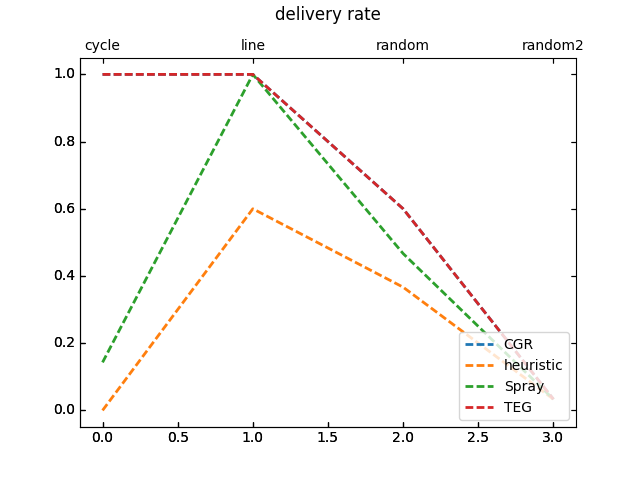

<IPython.core.display.Javascript object>


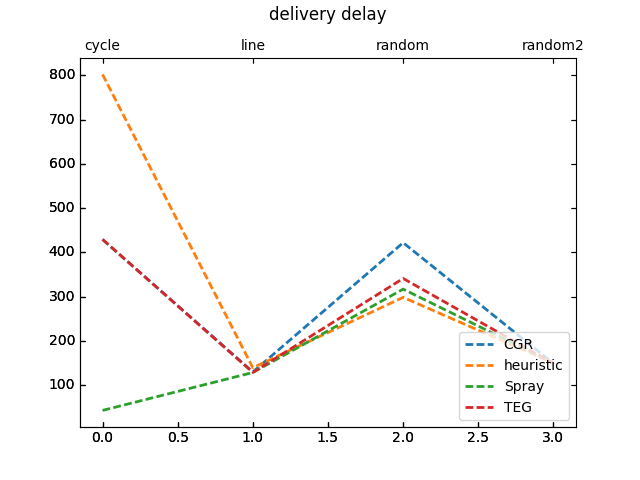

====================== draw one senario by name =======================


<IPython.core.display.Javascript object>


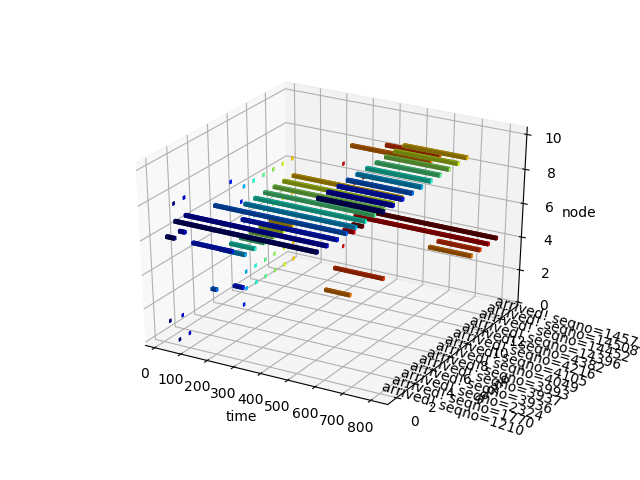

colors count=14
len of seqno_number_list=14
range(0, 14)


In [74]:
%matplotlib notebook
import re
import sys
import inspect
from math import sqrt
import numpy as np
from scipy import integrate
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import jsonpickle
from matplotlib.colors import cnames
from matplotlib import animation

#################################################
#################################
######### definition
#                                                                                    dstination
#x_time_trace_map = {} # seqno -> [src_t, sr_id, hop_t, rec_t, rec_id, hop_t, ... , rec_t, rec_id, x_simulation_time]
#x_tosend_list = [] # element is also a list [source, time, destination, seqno] this is used to substitude x_schedule_list

def handy_print_2(seqno, p_x_tosend_list) :
    for xs in p_x_tosend_list :
        if xs[3] == seqno :
            print('schedule is: from node-{0} to node-{1} at time-{2}'.format(xs[0], xs[2], xs[1]))
            break
def handy_print_0(st, et, nid) :
    print('from time-{0} => time-{1} in node-{2}'.format(st, et, nid))
def handy_print_1(key, value, p_x_tosend_list) :
    print('==================\npkt-seqno:{0}, trace is: '.format(key))
    n_v = int(len(value) / 3)
    is_arrived_traffic = False
    if (n_v * 3 == len(value)) :
        is_arrived_traffic = True
    if (is_arrived_traffic) :
        for cur in range(0, n_v, 1) :
            if cur == n_v - 1 :
                print('received by node-{1} at time-{0} destination :)'.format(value[cur * 3], value[cur * 3 + 1]))
            else :
                handy_print_0(value[cur * 3], value[cur * 3 + 2], value[cur * 3 + 1])
        print('arrived destination\n')
    else :
        for cur in range(0, n_v + 1, 1) :
            if cur == n_v :
                print('received by node-{1} at time-{0}, not destination :('.format(value[cur * 3], value[cur * 3 + 1]))
                if cur == 0 :
                    print('this bundle may not be transmit out from source')
            else :
                handy_print_0(value[cur * 3], value[cur * 3 + 2], value[cur * 3 + 1])
        print('not arrived destination\n')
    handy_print_2(key, p_x_tosend_list)
def nums(s):
    try:
        return int(s)
    except ValueError:
        return float(s)
def handy_draw_0(ax0, st, et, nid, seqnoindex, c) :
    dx = et - st
    ax0.bar3d(st, seqnoindex, nid, dx + 1.0, 0.2, 0.2, alpha=0.1, color=c, linewidth=0) # alpha = abs(dz[i]/max(dz))
class JSONOB(object):
    def __init__(self, name, tosend_list_ob, time_trace_map_ob):
        self.name = name
        self.tosend_list_ob = tosend_list_ob
        self.time_trace_map_ob = time_trace_map_ob
    def get_name(self) :
        return self.name
    def get_map(self) :
        return self.time_trace_map_ob
    def get_list(self) :
        return self.tosend_list_ob
def save_this_jsonob_as(filename, jsonob_to) :
    fullpathname = './stuff folder/' + filename
    serialized_json = jsonpickle.encode(jsonob_to)
    with open(fullpathname, "w") as text_file:
        print(serialized_json, file=text_file)
def read_file_to_jsonob(filename) :
    with open(filename, "r") as file :
        lines = file.read()
        tmp_json_ob = jsonpickle.decode(lines)
        return tmp_json_ob
def draw_it(p_x_tosend_list, p_x_time_trace_map, p_x_simulation_time) :
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    colors = plt.cm.jet(np.linspace(0, 1, len(p_x_tosend_list)))
    seqno_number_list = []
    for xsele in p_x_tosend_list :
        seqno_number_list.append(xsele[3])  
    print('colors count={0}'.format(len(colors)))
    print('len of seqno_number_list={0}'.format(len(seqno_number_list)))
    print(range(0, len(seqno_number_list), 1))
    for c, zseqnoindex in zip(colors, range(0, len(seqno_number_list), 1)):
        this_seqno_no = seqno_number_list[zseqnoindex]
        trace_list_of_seqno = p_x_time_trace_map[this_seqno_no]
        rt_count = int(len(trace_list_of_seqno) / 3)
        is_arrived_traffic_0 = False
        if (rt_count * 3 == len(trace_list_of_seqno)) :
            is_arrived_traffic_0 = True
            
        if is_arrived_traffic_0 :
            for cur in range(0, rt_count, 1) :
                if cur == rt_count - 1 :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'arrived! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
        else :
            for cur in range(0, rt_count + 1, 1) :
                if cur == rt_count :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3] + 1, \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'missed! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)

    ax.set_xlabel('time')
    ax.set_ylabel('seqno')
    ax.set_zlabel('node')
    plt.show()
def result_for_one_scenario(jsonob_one) :
    one_x_time_trace_map = jsonob_one.get_map()
    one_x_tosend_list = jsonob_one.get_list()
    print(one_x_tosend_list)
    for key, value in one_x_time_trace_map.items() :
        handy_print_1(key, value, one_x_tosend_list)
def abstract_value_from(jsonob_p) :
    j_time_trace_map = jsonob_p.get_map()
    j_tosend_list = jsonob_p.get_list()
    j_name = jsonob_p.get_name()
    r12 = re.compile('''([a-zA-Z]+[1-9]?)\swith\s([a-zA-Z]+)''', re.VERBOSE)
    r13 = re.compile('''arriveN\-(\d+\.*\d*)\-scheduleN\-(\d+\.*\d*)''', re.VERBOSE)
    name_tag = r12.search(j_name)
    senario_name = None
    routing_name = None
    arrived = None
    total = None
    if name_tag :
        senario_name = name_tag.group(1)
        routing_name = name_tag.group(2)
    else :
        print(j_name)
        print("eroor_01")
        sys.exit()
    schedule_tag = r13.search(j_name)
    if schedule_tag :
        arrived = int(nums(schedule_tag.group(1)))
        total = int(nums(schedule_tag.group(2)))
    else :
        print(schedule_tag)
        print("eroor_02")
        sys.exit()
    delivery_rate = round(float(arrived) /  float(total), 4)
    #
    total_delivery_time = 0
    for j_list in j_tosend_list :
        j_seqno = j_list[3]
        start_time = nums(j_list[1])
        #print(j_time_trace_map)
        j_trace = j_time_trace_map[str(j_seqno)]
        end_time = None
        if len(j_trace) % 3 == 0:
            end_time = nums(j_trace[len(j_trace) - 3])
        else :
            continue
        consume_time = end_time - start_time
        if consume_time < 0 :
            print("error_09:end_time={0}, start_time={1}, j_seqno={2}, routing_name={3}, senario_name={4}"
                  .format(end_time, start_time, j_seqno, routing_name, senario_name))
            sys.exit()
        total_delivery_time += consume_time
    average_delivery_delay = None
    if float(arrived) != 0.0 : 
        average_delivery_delay = float(total_delivery_time) / float(arrived)
    else :
        average_delivery_delay = 802
    return [senario_name, routing_name, delivery_rate, average_delivery_delay]
    # return [senario_name, routing_name, delivery_rate, average_delivery_delay]
def draw_jsonob_list(p_out_jsonob_list) :
    abstracted_v_list = []
    for jsonob in p_out_jsonob_list :
        abstracted_v = abstract_value_from(jsonob)
        abstracted_v_list.append(abstracted_v)
    #----
    map_of_one_line_of_delivery_rate = {}
    map_of_one_line_of_average_delivery_delay = {}
    list_of_line_route_name_k = []
    list_of_senario_name_k = []
    for abv in abstracted_v_list :
        if abv[1] not in list_of_line_route_name_k :
            list_of_line_route_name_k.append(abv[1])
        if abv[0] not in list_of_senario_name_k :
            list_of_senario_name_k.append(abv[0])
    print('abstracted_v_list')
    print(abstracted_v_list)
    for abvv in abstracted_v_list :
        map_key = abvv[1]
        sena_index = list_of_senario_name_k.index(abvv[0])
        if map_key in map_of_one_line_of_delivery_rate :
            drlist = map_of_one_line_of_delivery_rate[map_key]
            drlist[sena_index] = abvv[2]
            map_of_one_line_of_delivery_rate[map_key] = drlist
        else :
            tmpaddlist = [None] * len(list_of_senario_name_k)
            tmpaddlist[sena_index] = abvv[2]
            map_of_one_line_of_delivery_rate[map_key] = tmpaddlist
        if map_key in map_of_one_line_of_average_delivery_delay :
            drlist = map_of_one_line_of_average_delivery_delay[map_key]
            drlist[sena_index] = abvv[3]
            map_of_one_line_of_average_delivery_delay[map_key] = drlist
        else :
            tmpaddlist = [None] * len(list_of_senario_name_k)
            tmpaddlist[sena_index] = abvv[3]
            map_of_one_line_of_average_delivery_delay[map_key] = tmpaddlist
    print('\nmap_of_one_line_of_delivery_rate')
    print(map_of_one_line_of_delivery_rate)
    print('\nmap_of_one_line_of_average_delivery_delay')
    print(map_of_one_line_of_average_delivery_delay)
    print('\nlist_of_line_route_name_k')
    print(list_of_line_route_name_k)
    print('\nlist_of_senario_name_k')
    print(list_of_senario_name_k)
    draw_graph_of(map_of_one_line_of_delivery_rate, list_of_line_route_name_k, list_of_senario_name_k, 0)
    draw_graph_of(map_of_one_line_of_average_delivery_delay, list_of_line_route_name_k, list_of_senario_name_k, 1)
def draw_graph_of(map_of_one_line, list_of_line_route_name, list_of_senario_name, flag) :
    assert(len(map_of_one_line) == len(list_of_line_route_name))
    assert(map_of_one_line != None)
    assert(len(map_of_one_line[list_of_line_route_name[0]]) == len(list_of_senario_name))
    sena_num = len(list_of_senario_name)
    x = range(0, sena_num, 1)
    if flag == 0 :
        fig = plt.figure()
        #ax = fig.add_subplot(111, axes_class=AA.Axes, title='delivery_rate')
        ax = host_subplot(111, axes_class=AA.Axes)
        plt.title('delivery rate', y=1.08)
    else :
        fig = plt.figure()
        #ax = fig.add_subplot(111, axes_class=AA.Axes, title='delivery_delay')
        ax = host_subplot(111, axes_class=AA.Axes)
        plt.title('delivery delay', y=1.08)
    for name in list_of_line_route_name :
        #index = list_of_line_route_name.index(name)
        line = ax.plot(x, map_of_one_line[name], '--', linewidth = 2, label = name)
    ax.legend(loc='lower right')
    ax2 = ax.twin()  # ax2 is responsible for "top" axis and "right" axis
    ax2.set_xticks(x)
    ax2.set_xticklabels(list_of_senario_name)

    ax2.axis["right"].major_ticklabels.set_visible(False)
    ax2.axis["top"].major_ticklabels.set_visible(True)
    plt.show()
def draw_it_after_json(p_x_tosend_list, p_x_time_trace_map, p_x_simulation_time) :
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    colors = plt.cm.jet(np.linspace(0, 1, len(p_x_tosend_list)))
    seqno_number_list = []
    for xsele in p_x_tosend_list :
        seqno_number_list.append(xsele[3])  
    print('colors count={0}'.format(len(colors)))
    print('len of seqno_number_list={0}'.format(len(seqno_number_list)))
    print(range(0, len(seqno_number_list), 1))
    for c, zseqnoindex in zip(colors, range(0, len(seqno_number_list), 1)):
        this_seqno_no = seqno_number_list[zseqnoindex]
        trace_list_of_seqno = p_x_time_trace_map[str(this_seqno_no)]
        rt_count = int(len(trace_list_of_seqno) / 3)
        is_arrived_traffic_0 = False
        if (rt_count * 3 == len(trace_list_of_seqno)) :
            is_arrived_traffic_0 = True
            
        if is_arrived_traffic_0 :
            for cur in range(0, rt_count, 1) :
                if cur == rt_count - 1 :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'arrived! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
        else :
            for cur in range(0, rt_count + 1, 1) :
                if cur == rt_count :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3] + 1, \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)
                    ax.text(p_x_simulation_time, zseqnoindex, 0\
                            , 'missed! seqno={0}'.format(seqno_number_list[zseqnoindex]), 'x')
                else :
                    handy_draw_0(ax, trace_list_of_seqno[cur * 3], trace_list_of_seqno[cur * 3 + 2], \
                                 trace_list_of_seqno[cur * 3 + 1], zseqnoindex, c)

    ax.set_xlabel('time')
    ax.set_ylabel('seqno')
    ax.set_zlabel('node')
    plt.show()
def draw_one_senario_by_name(strname, out_jsonob_list_k) :
    for js_one_scenario in out_jsonob_list_k :
        if js_one_scenario.name == strname :
            that_x_time_trace_map = js_one_scenario.get_map()
            that_x_tosend_list = js_one_scenario.get_list()
            r14 = re.compile('''timeT\-(\d+\.*\d*)''', re.VERBOSE)
            timetag = r14.search(strname)
            that_simulation_time = None
            if timetag :
                that_simulation_time = nums(timetag.group(1))
            else :
                print("error_0123")
                sys.exit()
            draw_it_after_json(that_x_tosend_list, that_x_time_trace_map, that_simulation_time)
######## end of definition
###############################
#################################################

#=========
#== settings
file_name_list = ['./stuff folder/cycle with CGR-nodeN-11-timeT-802.0-arriveN-14-scheduleN-14',
                  './stuff folder/cycle with heuristic-nodeN-11-timeT-802.0-arriveN-0-scheduleN-14',
                  './stuff folder/cycle with Spray-nodeN-11-timeT-802.0-arriveN-2-scheduleN-14',
                  './stuff folder/cycle with TEG-nodeN-11-timeT-802.0-arriveN-14-scheduleN-14',
                  './stuff folder/line with CGR-nodeN-5-timeT-802.0-arriveN-5-scheduleN-5',
                  './stuff folder/line with heuristic-nodeN-5-timeT-802.0-arriveN-3-scheduleN-5',
                  './stuff folder/line with Spray-nodeN-5-timeT-802.0-arriveN-5-scheduleN-5',
                  './stuff folder/line with TEG-nodeN-5-timeT-802.0-arriveN-5-scheduleN-5',
                  './stuff folder/random with CGR-nodeN-15-timeT-802.0-arriveN-18-scheduleN-30',
                  './stuff folder/random with heuristic-nodeN-15-timeT-802.0-arriveN-11-scheduleN-30',
                  './stuff folder/random with Spray-nodeN-15-timeT-802.0-arriveN-14-scheduleN-30',
                  './stuff folder/random with TEG-nodeN-15-timeT-802.0-arriveN-18-scheduleN-30',
                  './stuff folder/random2 with CGR-nodeN-15-timeT-802.0-arriveN-1-scheduleN-30',
                  './stuff folder/random2 with heuristic-nodeN-15-timeT-802.0-arriveN-1-scheduleN-30',
                  './stuff folder/random2 with Spray-nodeN-15-timeT-802.0-arriveN-1-scheduleN-30',
                  './stuff folder/random2 with TEG-nodeN-15-timeT-802.0-arriveN-1-scheduleN-30',                 
                 ]
#== end of settings
#=================
print('====================== read serialized json =====================')
out_jsonob_list = []
for filename in file_name_list :
    out_jsonob_list.append(read_file_to_jsonob(filename))
if len(out_jsonob_list) < 1 :
    print('error_04')
for js_one_scenario in out_jsonob_list :
    print('''┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐   FOR   ONE  JSON  FILE  ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐ ┌∩┐(◣_◢)┌∩┐''')
    print('=========== name:{0} ======='.format(js_one_scenario.name))
    result_for_one_scenario(js_one_scenario)
print('====================== good ending =======================')
print('====================== draw jsonob list =======================')
draw_jsonob_list(out_jsonob_list)
print('====================== draw one senario by name =======================')
draw_one_senario_by_name('cycle with CGR-nodeN-11-timeT-802.0-arriveN-14-scheduleN-14', out_jsonob_list)